' Save model '

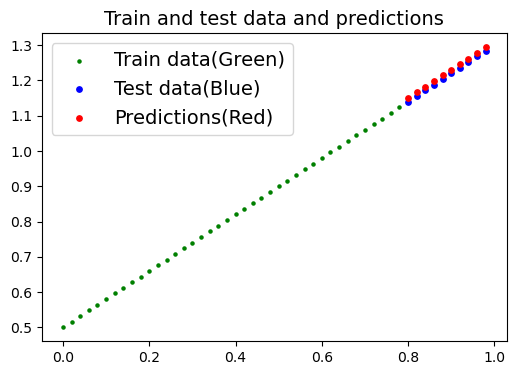

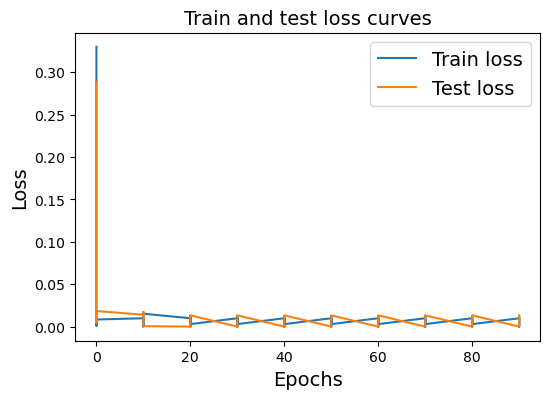

In [7]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

""" Prepare dataset """
weight = 0.8
bias = 0.5

X = torch.tensor([[0.00], [0.02], [0.04], [0.06], [0.08], # Size(50, 1)
                  [0.10], [0.12], [0.14], [0.16], [0.18],
                  [0.20], [0.22], [0.24], [0.26], [0.28],
                  [0.30], [0.32], [0.34], [0.36], [0.38],
                  [0.40], [0.42], [0.44], [0.46], [0.48],
                  [0.50], [0.52], [0.54], [0.56], [0.58],
                  [0.60], [0.62], [0.64], [0.66], [0.68],
                  [0.70], [0.72], [0.74], [0.76], [0.78],
                  [0.80], [0.82], [0.84], [0.86], [0.88],
                  [0.90], [0.92], [0.94], [0.96], [0.98]], device=device)
torch.manual_seed(42)

# ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ Uncomment it to shuffle dataset ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓
# X = list(DataLoader(dataset=X, batch_size=50, shuffle=True))[0] 

Y = weight * X + bias

l = int(0.8 * len(X))
X_train, Y_train, X_test, Y_test = X[:l], Y[:l], X[l:], Y[l:]
""" Prepare dataset """

""" Prepare model, loss function and optimizer """
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        return self.linear_layer(x)

torch.manual_seed(42)

my_model = LinearRegressionModel().to(device)

# """ Load model """
# loaded_model = torch.load(f="lr_bgd_dl_0.pth",
#                           weights_only=True)
# my_model.load_state_dict(loaded_model)
# """ Load model """

loss_fn = nn.L1Loss()

optimizer = optim.SGD(params=my_model.parameters(), lr=0.01)
""" Prepare model, loss function and optimizer """

""" Train and test model """
epochs = 100

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    X_train_dl = DataLoader(dataset=X_train, batch_size=40) # BGD
    Y_train_dl = DataLoader(dataset=Y_train, batch_size=40) # BGD
    # X_train_dl = DataLoader(dataset=X_train, batch_size=10) # MBGD
    # Y_train_dl = DataLoader(dataset=Y_train, batch_size=10) # MBGD
    # X_train_dl = DataLoader(dataset=X_train, batch_size=1)  # SGD
    # Y_train_dl = DataLoader(dataset=Y_train, batch_size=1)  # SGD
    X_Y_train_dl = zip(X_train_dl, Y_train_dl)
    for X_train_batch, Y_train_batch in X_Y_train_dl:

        """ Train """
        my_model.train()

        # 1. Calculate predictions(Forward propagation)
        Y_pred = my_model(X_train_batch)

        # 2. Calculate loss
        loss = loss_fn(Y_pred, Y_train_batch)

        # 3. Zero out gradients
        optimizer.zero_grad()

        # 4. Calculate a gradient(Backpropagation)
        loss.backward()

        # 5. Update parameters
        optimizer.step()
        """ Train """        

        """ Test """
        my_model.eval()

        with torch.inference_mode():
            Y_test_pred = my_model(x=X_test)
            test_loss = loss_fn(Y_test_pred, Y_test)
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            # print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
            # ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ Uncomment it to see the details ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑
        """ Test """
""" Train and test model """

""" Visualize train and test data and predictions"""
with torch.inference_mode():
    Y_pred = my_model(x=X_test)

def plot_predictions(X_train, Y_train, X_test, Y_test, predictions=None):
    plt.figure(figsize=[6, 4])
    plt.scatter(X_train, Y_train, c='g', s=5, label='Train data(Green)')
    plt.scatter(X_test, Y_test, c='b', s=15, label='Test data(Blue)')
    if predictions is not None:
        plt.scatter(X_test, predictions, c='r', s=15, label='Predictions(Red)')
    plt.title(label="Train and test data and predictions", fontsize=14)
    plt.legend(fontsize=14)

plot_predictions(X_train=X_train.cpu(),
                 Y_train=Y_train.cpu(),
                 X_test=X_test.cpu(),
                 Y_test=Y_test.cpu(),
                 predictions=Y_pred.cpu())
""" Visualize train and test data, predictions"""

""" Visualize train and test loss """
def plot_loss_curves(epoch_count, loss_values, test_loss_values):
    plt.figure(figsize=[6, 4])
    plt.plot(epoch_count, loss_values, label="Train loss")
    plt.plot(epoch_count, test_loss_values, label="Test loss")
    plt.title(label="Train and test loss curves", fontsize=14)
    plt.ylabel(ylabel="Loss", fontsize=14)
    plt.xlabel(xlabel="Epochs", fontsize=14)
    plt.legend(fontsize=14)

plot_loss_curves(epoch_count=epoch_count,
                 loss_values=torch.tensor(loss_values).cpu(),
                 test_loss_values=torch.tensor(test_loss_values).cpu())
""" Visualize train and test loss """

""" Save model """
from pathlib import Path

MODEL_PATH = Path("results")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lr_bgd_dl_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=my_model.state_dict(), f=MODEL_SAVE_PATH)
""" Save model """